In [1]:
from process_bigraph import Composite
from process_bigraph.composite import ProcessTypes

from cdFBA import register_types
from cdFBA.processes.dfba import DFBA, UpdateEnvironment, Chemostat, Injector, WaveFunction

from cdFBA.utils import make_cdfba_composite, get_injector_spec, get_wave_spec, get_chemo_spec

from matplotlib import pyplot as plt
from pprint import pprint

#TODO: Figure out why results are different from previous demo

<unknown>:1: SyntaxWarning: invalid escape sequence '\s'


# Create Composite Spec for cdFBA Simulation

Automatically generate basic specs for two species of bacteria, *Escherichia coli* and *Shigella flexneri*. We will be using the utility functions found in [this file](https://github.com/vivarium-collective/cdFBA/blob/main/cdFBA/utils.py).

NOTE: The utility functions use the model file's own reaction naming conventions to obtain the name of substrates. These names are not consistent across all metabolic model databases. We have tested these functions on BiGG and AGORA metabolic models and found the naming conventions to be consistent within their respective databases. When using models from different sources, users are advised to map their reactions and substrates of interest before running cdFBA simulations, and avoid the built-in utility functions for creating simulations.

In [2]:
#Create a model dictionary. The keys should be the names of the individual dFBA models/species and the values should be
#BiGG model ids or the path name to the associated model file
model_dict = {
        'E.coli' : 'iAF1260',
        'S.flexneri' : 'iSFxv_1172'
    }
#list exchange reactions
exchanges = ['EX_glc__D_e', 'EX_ac_e']
#set environment volume
volume=1
# define a single dFBA model
spec = make_cdfba_composite(model_dict, medium_type=None, exchanges=exchanges, volume=volume, interval=1.0)

pprint(spec)

{'E.coli': {'_type': 'process',
            'address': 'local:DFBA',
            'config': {'biomass_identifier': 'BIOMASS_Ec_iAF1260_core_59p81M',
                       'bounds': {},
                       'kinetics': {'Acetate': (0.5, 2.0),
                                    'D-Glucose': (0.5, 2.0)},
                       'model_file': 'iAF1260',
                       'name': 'E.coli',
                       'reaction_map': {'Acetate': 'EX_ac_e',
                                        'D-Glucose': 'EX_glc__D_e'}},
            'inputs': {'current_update': ['dFBA Results'],
                       'shared_environment': ['shared environment']},
            'interval': 1.0,
            'outputs': {'dfba_update': ['dFBA Results', 'E.coli']}},
 'S.flexneri': {'_type': 'process',
                'address': 'local:DFBA',
                'config': {'biomass_identifier': 'BIOMASS_Ec_iJO1366_core_53p95M',
                           'bounds': {},
                           'kinetics': {'Acet

In [3]:
#Set reaction bounds
spec['E.coli']['config']['bounds'] = {
            "EX_o2_e": {"lower": -2, "upper": None},
            "ATPM": {"lower": 1, "upper": 1}
        }
spec['S.flexneri']['config']['bounds'] = {
            "EX_o2_e": {"lower": -2, "upper": None},
            "ATPM": {"lower": 1, "upper": 1}
        }

In [4]:
#set initial concentrations
spec['shared environment']['counts']['Acetate'] = 0
spec['shared environment']['concentrations']['Acetate'] = 0/volume
spec['shared environment']['counts']['D-Glucose'] = 80
spec['shared environment']['concentrations']['D-Glucose'] = 80/volume

# Register Data Types and Processes
Here we register cdFBA related data-types and processes to the `core` object so that the model composite can access them. A `core` object is instantiated using the `ProcessType()` function. Data types are defined in the `init.py` file, and the `register_types()` function registers them to the `core` object. Process registration is done using the `core.register_process()` function.

In [5]:
#create the core object
core = ProcessTypes()
#register data types
core = register_types(core)
#register all processes and steps
core.register_process('DFBA', DFBA)
core.register_process('UpdateEnvironment', UpdateEnvironment)
core.register_process('Chemostat', Chemostat)
core.register_process('WaveFunction', WaveFunction)
core.register_process('Injector', Injector)

### Create Simulation Composite
The `Composite` class creates the simulation object using the spec created earlier.

In [6]:
#create simulation composite
sim = Composite({
        "state": spec,
        "emitter": {'mode': 'all'}},
        core=core
    )

In [7]:
#run simulation
sim.run(40)

/opt/anaconda3/envs/cdFBA/lib/python3.12/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


In [8]:
#gather results
results = sim.gather_results()[('emitter',)]

In [9]:
#extract time-series data
timepoints = []
for timepoint in results:
    time = timepoint.pop('global_time')
    timepoints.append(time)
    dfba_spec = timepoint.pop(list(model_dict.keys())[0])
    print(f'TIME: {time}')
    pprint(f'STATE: {timepoint}')
    env = [timepoint['shared environment']['concentrations'] for timepoint in results]
env_combined = {}
for d in env:
    for key, value in d.items():
        if key not in env_combined:
            env_combined[key] = []
        env_combined[key].append(value)

TIME: 0.0
("STATE: {'dFBA Results': {'E.coli': {'D-Glucose': 0, 'Acetate': 0, 'E.coli': "
 "0}, 'S.flexneri': {'D-Glucose': 0, 'Acetate': 0, 'S.flexneri': 0}}, 'shared "
 "environment': {'concentrations': {'D-Glucose': 80.0, 'Acetate': 0.0, "
 "'E.coli': 0.5, 'S.flexneri': 0.5}, 'counts': {'D-Glucose': 80, 'Acetate': 0, "
 "'E.coli': 0.5, 'S.flexneri': 0.5}, 'volume': 1}, 'S.flexneri': {'inputs': "
 "{'shared_environment': ['shared environment'], 'current_update': ['dFBA "
 "Results']}, 'outputs': {'dfba_update': ['dFBA Results', 'S.flexneri']}, "
 "'interval': 1.0, 'address': 'local:DFBA', 'config': {'model_file': "
 "'iSFxv_1172', 'name': 'S.flexneri', 'kinetics': {'D-Glucose': (0.5, 2.0), "
 "'Acetate': (0.5, 2.0)}, 'reaction_map': {'D-Glucose': 'EX_glc__D_e', "
 "'Acetate': 'EX_ac_e'}, 'biomass_identifier': "
 "'BIOMASS_Ec_iJO1366_core_53p95M', 'bounds': {'EX_o2_e': {'lower': -2.0, "
 "'upper': None}, 'ATPM': {'lower': 1.0, 'upper': 1.0}}}, 'instance': "
 "<cdFBA.processes.dfba.DFB

In [10]:
#extract time-series for the shared environment
env = [timepoint['shared environment']['concentrations'] for timepoint in results]
env_combined = {}
for d in env:
    for key, value in d.items():
        if key not in env_combined:
            env_combined[key] = []
        env_combined[key].append(value)

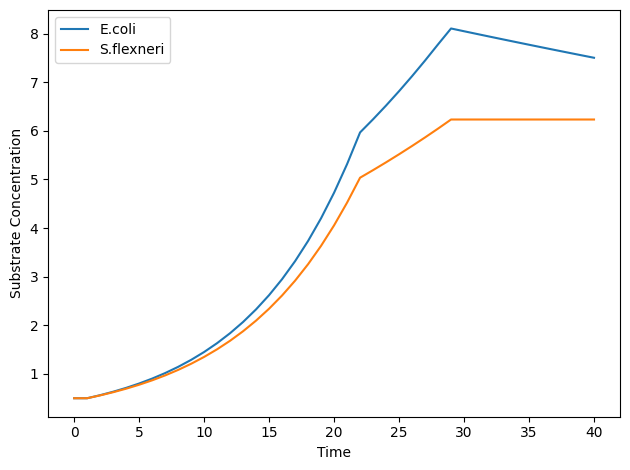

In [11]:
#plot results for biomass
fig, ax = plt.subplots(dpi=100)
for key, value in env_combined.items():
    if key not in ['D-Glucose', 'Acetate']:
        ax.plot(timepoints, env_combined[key], label=key)
plt.xlabel('Time')
plt.ylabel('Substrate Concentration')
plt.legend()
plt.tight_layout()
plt.show()

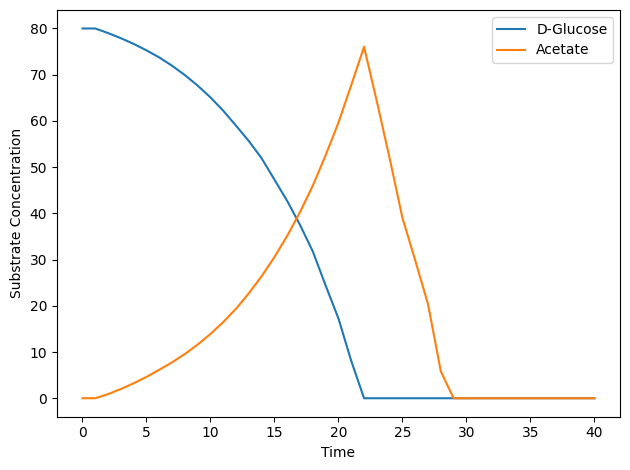

In [12]:
#plote substrates
fig, ax = plt.subplots(dpi=100)
for key, value in env_combined.items():
    if key in ['D-Glucose', 'Acetate']:
        ax.plot(timepoints, env_combined[key], label=key)
plt.xlabel('Time')
plt.ylabel('Substrate Concentration')
plt.legend()
plt.tight_layout()
plt.show()

In [13]:
spec['shared environment']

{'volume': 1,
 'counts': {'D-Glucose': 80, 'Acetate': 0, 'E.coli': 0.5, 'S.flexneri': 0.5},
 'concentrations': {'D-Glucose': 80.0,
  'Acetate': 0.0,
  'E.coli': 0.5,
  'S.flexneri': 0.5}}